# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Thu May  8 22:22:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   36C    P5             18W /   80W |     586MiB /   6144MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGeneratorDeep
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/deep_model",
    checkpoints_dir="../checkpoints/deep_model",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="deep",  # Koristimo standardnu arhitekturu
    sample_interval=50,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: deep
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [17]:
import torch
import gc

# Očistite memoriju
torch.cuda.empty_cache()
gc.collect()

7324

In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A_loss=0.1754, D_B_loss=0.0631, G_loss=3.1746]


Epoha 1/150 - Train gubici: G: 10.1116, D_A: 0.5440, D_B: 0.5677 | Val gubici: G: 2.3295, Cycle: 1.4664
Novi najbolji validacijski gubitak: 1.4664, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:30<00:00,  3.76it/s, D_A_loss=0.2967, D_B_loss=0.2794, G_loss=2.2284]


Epoha 2/150 - Train gubici: G: 2.6581, D_A: 0.2341, D_B: 0.1832 | Val gubici: G: 1.8692, Cycle: 1.5123


Epoha 3/150: 100%|██████████| 115/115 [00:30<00:00,  3.76it/s, D_A_loss=0.2614, D_B_loss=0.2666, G_loss=1.8994]


Epoha 3/150 - Train gubici: G: 2.0774, D_A: 0.2534, D_B: 0.2355 | Val gubici: G: 1.3824, Cycle: 0.9330
Novi najbolji validacijski gubitak: 0.9330, spremam modele...


Epoha 4/150: 100%|██████████| 115/115 [00:29<00:00,  3.84it/s, D_A_loss=0.3269, D_B_loss=0.3175, G_loss=1.8478]


Epoha 4/150 - Train gubici: G: 1.8893, D_A: 0.2442, D_B: 0.2376 | Val gubici: G: 1.6395, Cycle: 0.9392


Epoha 5/150: 100%|██████████| 115/115 [00:29<00:00,  3.84it/s, D_A_loss=0.2347, D_B_loss=0.2324, G_loss=2.2921]


Epoha 5/150 - Train gubici: G: 1.8515, D_A: 0.2459, D_B: 0.2401 | Val gubici: G: 1.3641, Cycle: 0.9143
Novi najbolji validacijski gubitak: 0.9143, spremam modele...


Epoha 6/150: 100%|██████████| 115/115 [00:29<00:00,  3.84it/s, D_A_loss=0.3407, D_B_loss=0.2848, G_loss=2.3513]


Epoha 6/150 - Train gubici: G: 1.7918, D_A: 0.2481, D_B: 0.2443 | Val gubici: G: 1.8637, Cycle: 1.0082


Epoha 7/150: 100%|██████████| 115/115 [00:29<00:00,  3.84it/s, D_A_loss=0.1811, D_B_loss=0.1278, G_loss=1.5632]


Epoha 7/150 - Train gubici: G: 1.7338, D_A: 0.2463, D_B: 0.2299 | Val gubici: G: 1.3884, Cycle: 1.0573


Epoha 8/150: 100%|██████████| 115/115 [00:29<00:00,  3.84it/s, D_A_loss=0.2916, D_B_loss=0.3193, G_loss=1.6943]


Epoha 8/150 - Train gubici: G: 1.6932, D_A: 0.2506, D_B: 0.2374 | Val gubici: G: 1.6062, Cycle: 0.8854
Novi najbolji validacijski gubitak: 0.8854, spremam modele...


Epoha 9/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.2127, D_B_loss=0.2306, G_loss=1.5587]


Epoha 9/150 - Train gubici: G: 1.6413, D_A: 0.2503, D_B: 0.2353 | Val gubici: G: 1.2520, Cycle: 0.7769
Novi najbolji validacijski gubitak: 0.7769, spremam modele...


Epoha 10/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.2376, D_B_loss=0.2193, G_loss=1.6267]


Epoha 10/150 - Train gubici: G: 1.6195, D_A: 0.2526, D_B: 0.2379 | Val gubici: G: 1.3079, Cycle: 0.8025


Epoha 11/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.2015, D_B_loss=0.3709, G_loss=1.6581]


Epoha 11/150 - Train gubici: G: 1.6634, D_A: 0.2563, D_B: 0.2328 | Val gubici: G: 1.1870, Cycle: 0.8321


Epoha 12/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.1940, D_B_loss=0.2496, G_loss=1.6154]


Epoha 12/150 - Train gubici: G: 1.6113, D_A: 0.2509, D_B: 0.2249 | Val gubici: G: 1.0755, Cycle: 0.8156


Epoha 13/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3071, D_B_loss=0.3947, G_loss=1.4912]


Epoha 13/150 - Train gubici: G: 1.5540, D_A: 0.2427, D_B: 0.2281 | Val gubici: G: 1.3297, Cycle: 0.8074


Epoha 14/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1857, D_B_loss=0.3382, G_loss=1.1916]


Epoha 14/150 - Train gubici: G: 1.5235, D_A: 0.2428, D_B: 0.2193 | Val gubici: G: 1.3955, Cycle: 0.7011
Novi najbolji validacijski gubitak: 0.7011, spremam modele...


Epoha 15/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.2194, D_B_loss=0.1196, G_loss=1.3386]


Epoha 15/150 - Train gubici: G: 1.4979, D_A: 0.3006, D_B: 0.2230 | Val gubici: G: 1.0999, Cycle: 0.6560
Novi najbolji validacijski gubitak: 0.6560, spremam modele...


Epoha 16/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2411, D_B_loss=0.3212, G_loss=1.1287]


Epoha 16/150 - Train gubici: G: 1.4616, D_A: 0.2429, D_B: 0.2154 | Val gubici: G: 1.1223, Cycle: 0.6456
Novi najbolji validacijski gubitak: 0.6456, spremam modele...


Epoha 17/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3756, D_B_loss=0.2075, G_loss=1.7988]


Epoha 17/150 - Train gubici: G: 1.4968, D_A: 0.2451, D_B: 0.2087 | Val gubici: G: 1.2811, Cycle: 0.6272
Novi najbolji validacijski gubitak: 0.6272, spremam modele...


Epoha 18/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2124, D_B_loss=0.2177, G_loss=1.7405]


Epoha 18/150 - Train gubici: G: 1.6917, D_A: 0.2432, D_B: 0.2069 | Val gubici: G: 1.2402, Cycle: 0.8128


Epoha 19/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2670, D_B_loss=0.2253, G_loss=3.4599]


Epoha 19/150 - Train gubici: G: 1.6107, D_A: 0.2413, D_B: 0.2075 | Val gubici: G: 2.4351, Cycle: 1.1955


Epoha 20/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2146, D_B_loss=0.1245, G_loss=1.2307]


Epoha 20/150 - Train gubici: G: 1.4777, D_A: 0.2644, D_B: 0.2210 | Val gubici: G: 1.1425, Cycle: 0.6266
Novi najbolji validacijski gubitak: 0.6266, spremam modele...


Epoha 21/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.2164, D_B_loss=0.1565, G_loss=1.4929]


Epoha 21/150 - Train gubici: G: 1.4313, D_A: 0.2394, D_B: 0.2262 | Val gubici: G: 1.5134, Cycle: 0.7808


Epoha 22/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2323, D_B_loss=0.2725, G_loss=1.3705]


Epoha 22/150 - Train gubici: G: 1.4640, D_A: 0.2448, D_B: 0.2259 | Val gubici: G: 1.2480, Cycle: 0.7357


Epoha 23/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1897, D_B_loss=0.2277, G_loss=1.3851]


Epoha 23/150 - Train gubici: G: 1.4464, D_A: 0.2439, D_B: 0.2165 | Val gubici: G: 1.0500, Cycle: 0.7478


Epoha 24/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2820, D_B_loss=0.2985, G_loss=1.4012]


Epoha 24/150 - Train gubici: G: 1.4546, D_A: 0.2504, D_B: 0.2252 | Val gubici: G: 1.5784, Cycle: 0.7958


Epoha 25/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2003, D_B_loss=0.0890, G_loss=1.6872]


Epoha 25/150 - Train gubici: G: 1.4325, D_A: 0.2383, D_B: 0.2247 | Val gubici: G: 1.2698, Cycle: 0.7343


Epoha 26/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2286, D_B_loss=0.1540, G_loss=1.7808]


Epoha 26/150 - Train gubici: G: 1.4211, D_A: 0.2410, D_B: 0.2156 | Val gubici: G: 2.2145, Cycle: 0.7531


Epoha 27/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1762, D_B_loss=0.2806, G_loss=1.2625]


Epoha 27/150 - Train gubici: G: 1.4328, D_A: 0.2450, D_B: 0.2244 | Val gubici: G: 1.5364, Cycle: 0.7285


Epoha 28/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2475, D_B_loss=0.2033, G_loss=1.0812]


Epoha 28/150 - Train gubici: G: 1.4335, D_A: 0.3287, D_B: 0.2194 | Val gubici: G: 1.1398, Cycle: 0.5685
Novi najbolji validacijski gubitak: 0.5685, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2076, D_B_loss=0.1167, G_loss=1.3377]


Epoha 29/150 - Train gubici: G: 1.2826, D_A: 0.2394, D_B: 0.2189 | Val gubici: G: 1.2384, Cycle: 0.6375


Epoha 30/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2031, D_B_loss=0.2607, G_loss=1.1717]


Epoha 30/150 - Train gubici: G: 1.3388, D_A: 0.2430, D_B: 0.2145 | Val gubici: G: 1.3414, Cycle: 0.6725


Epoha 31/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2244, D_B_loss=0.1323, G_loss=1.3087]


Epoha 31/150 - Train gubici: G: 1.3701, D_A: 0.2430, D_B: 0.2207 | Val gubici: G: 1.0283, Cycle: 0.6536


Epoha 32/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2193, D_B_loss=0.1315, G_loss=1.4747]


Epoha 32/150 - Train gubici: G: 1.3759, D_A: 0.2463, D_B: 0.2193 | Val gubici: G: 1.1474, Cycle: 0.7222


Epoha 33/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2768, D_B_loss=0.3213, G_loss=1.5038]


Epoha 33/150 - Train gubici: G: 1.3596, D_A: 0.2313, D_B: 0.2148 | Val gubici: G: 0.9361, Cycle: 0.5827


Epoha 34/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3048, D_B_loss=0.1288, G_loss=1.1723]


Epoha 34/150 - Train gubici: G: 1.3372, D_A: 0.2556, D_B: 0.2177 | Val gubici: G: 1.4346, Cycle: 0.6286


Epoha 35/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2274, D_B_loss=0.2621, G_loss=1.4930]


Epoha 35/150 - Train gubici: G: 1.3479, D_A: 0.2432, D_B: 0.2223 | Val gubici: G: 1.3222, Cycle: 0.6822


Epoha 36/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2222, D_B_loss=0.2455, G_loss=1.3049]


Epoha 36/150 - Train gubici: G: 1.3831, D_A: 0.2394, D_B: 0.2117 | Val gubici: G: 1.2060, Cycle: 0.5960


Epoha 37/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.4375, D_B_loss=0.1276, G_loss=1.6092]


Epoha 37/150 - Train gubici: G: 1.3967, D_A: 0.2333, D_B: 0.2136 | Val gubici: G: 1.3834, Cycle: 0.6494


Epoha 38/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2476, D_B_loss=0.1379, G_loss=1.3907]


Epoha 38/150 - Train gubici: G: 1.3872, D_A: 0.2426, D_B: 0.2083 | Val gubici: G: 1.2277, Cycle: 0.6003


Epoha 39/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3035, D_B_loss=0.2317, G_loss=1.0298]


Epoha 39/150 - Train gubici: G: 1.3709, D_A: 0.2300, D_B: 0.2130 | Val gubici: G: 1.2438, Cycle: 0.6229


Epoha 40/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2146, D_B_loss=0.1362, G_loss=1.0896]


Epoha 40/150 - Train gubici: G: 1.4018, D_A: 0.2264, D_B: 0.2203 | Val gubici: G: 0.9040, Cycle: 0.5867


Epoha 41/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3459, D_B_loss=0.3575, G_loss=1.6183]


Epoha 41/150 - Train gubici: G: 1.3788, D_A: 0.2205, D_B: 0.2131 | Val gubici: G: 1.4289, Cycle: 0.7159


Epoha 42/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1756, D_B_loss=0.1631, G_loss=2.0402]


Epoha 42/150 - Train gubici: G: 1.4024, D_A: 0.2253, D_B: 0.2069 | Val gubici: G: 1.3871, Cycle: 0.6190


Epoha 43/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1881, D_B_loss=0.1449, G_loss=1.3291]


Epoha 43/150 - Train gubici: G: 1.4219, D_A: 0.2127, D_B: 0.2096 | Val gubici: G: 1.0097, Cycle: 0.7732


Epoha 44/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2803, D_B_loss=0.2720, G_loss=1.3712]


Epoha 44/150 - Train gubici: G: 1.3985, D_A: 0.2287, D_B: 0.2097 | Val gubici: G: 1.3910, Cycle: 0.6968


Epoha 45/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2222, D_B_loss=0.2361, G_loss=2.0215]


Epoha 45/150 - Train gubici: G: 1.3638, D_A: 0.2295, D_B: 0.2051 | Val gubici: G: 1.8702, Cycle: 0.8803


Epoha 46/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1602, D_B_loss=0.0522, G_loss=1.3451]


Epoha 46/150 - Train gubici: G: 1.4215, D_A: 0.2107, D_B: 0.2021 | Val gubici: G: 1.4260, Cycle: 0.7351


Epoha 47/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1697, D_B_loss=0.2087, G_loss=1.3650]


Epoha 47/150 - Train gubici: G: 1.3801, D_A: 0.2284, D_B: 0.2078 | Val gubici: G: 0.8798, Cycle: 0.6573


Epoha 48/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1714, D_B_loss=0.2956, G_loss=1.3061]


Epoha 48/150 - Train gubici: G: 1.3959, D_A: 0.2035, D_B: 0.1980 | Val gubici: G: 1.4731, Cycle: 0.5859


Epoha 49/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2120, D_B_loss=0.1247, G_loss=1.2248]


Epoha 49/150 - Train gubici: G: 1.4316, D_A: 0.2550, D_B: 0.2006 | Val gubici: G: 1.4894, Cycle: 0.6874


Epoha 50/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1844, D_B_loss=0.3760, G_loss=1.5084]


Epoha 50/150 - Train gubici: G: 1.4564, D_A: 0.2056, D_B: 0.1991 | Val gubici: G: 1.4401, Cycle: 0.7642


Epoha 51/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1960, D_B_loss=0.2229, G_loss=1.3304]


Epoha 51/150 - Train gubici: G: 1.3938, D_A: 0.1997, D_B: 0.2026 | Val gubici: G: 1.0953, Cycle: 0.6672


Epoha 52/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0927, D_B_loss=0.2507, G_loss=1.0121]


Epoha 52/150 - Train gubici: G: 1.3765, D_A: 0.2061, D_B: 0.1925 | Val gubici: G: 1.2272, Cycle: 0.6713


Epoha 53/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1481, D_B_loss=0.1977, G_loss=1.9011]


Epoha 53/150 - Train gubici: G: 1.3501, D_A: 0.2046, D_B: 0.2059 | Val gubici: G: 1.3210, Cycle: 0.6212


Epoha 54/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1893, D_B_loss=0.1006, G_loss=1.7047]


Epoha 54/150 - Train gubici: G: 1.3904, D_A: 0.1964, D_B: 0.2020 | Val gubici: G: 1.7121, Cycle: 0.6392


Epoha 55/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1746, D_B_loss=0.1333, G_loss=1.7906]


Epoha 55/150 - Train gubici: G: 1.4366, D_A: 0.1897, D_B: 0.1855 | Val gubici: G: 0.8307, Cycle: 0.6146


Epoha 56/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1954, D_B_loss=0.1804, G_loss=1.4122]


Epoha 56/150 - Train gubici: G: 1.3907, D_A: 0.1872, D_B: 0.1984 | Val gubici: G: 1.1764, Cycle: 0.7084


Epoha 57/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2604, D_B_loss=0.3413, G_loss=1.4585]


Epoha 57/150 - Train gubici: G: 1.4356, D_A: 0.1884, D_B: 0.1912 | Val gubici: G: 1.6321, Cycle: 0.6503


Epoha 58/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2067, D_B_loss=0.0903, G_loss=1.2008]


Epoha 58/150 - Train gubici: G: 1.4000, D_A: 0.2026, D_B: 0.1841 | Val gubici: G: 1.1487, Cycle: 0.5893


Epoha 59/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2283, D_B_loss=0.1740, G_loss=1.2881]


Epoha 59/150 - Train gubici: G: 1.3928, D_A: 0.2000, D_B: 0.1892 | Val gubici: G: 1.7695, Cycle: 0.6620


Epoha 60/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2370, D_B_loss=0.1829, G_loss=1.3278]


Epoha 60/150 - Train gubici: G: 1.4098, D_A: 0.1930, D_B: 0.1977 | Val gubici: G: 1.8949, Cycle: 0.6539


Epoha 61/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.3048, D_B_loss=0.0776, G_loss=1.4307]


Epoha 61/150 - Train gubici: G: 1.3742, D_A: 0.1942, D_B: 0.1921 | Val gubici: G: 1.5185, Cycle: 0.7557


Epoha 62/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1139, D_B_loss=0.0900, G_loss=1.1941]


Epoha 62/150 - Train gubici: G: 1.3664, D_A: 0.1981, D_B: 0.1891 | Val gubici: G: 0.8495, Cycle: 0.5670
Novi najbolji validacijski gubitak: 0.5670, spremam modele...


Epoha 63/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2402, D_B_loss=0.2438, G_loss=1.1172]


Epoha 63/150 - Train gubici: G: 1.3801, D_A: 0.1946, D_B: 0.1781 | Val gubici: G: 2.1094, Cycle: 0.6196


Epoha 64/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2627, D_B_loss=0.2294, G_loss=1.2049]


Epoha 64/150 - Train gubici: G: 1.4453, D_A: 0.1874, D_B: 0.1752 | Val gubici: G: 1.6303, Cycle: 0.5913


Epoha 65/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.2142, D_B_loss=0.1566, G_loss=1.1407]


Epoha 65/150 - Train gubici: G: 1.4475, D_A: 0.1830, D_B: 0.1681 | Val gubici: G: 1.7790, Cycle: 0.6243


Epoha 66/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2072, D_B_loss=0.1066, G_loss=1.4029]


Epoha 66/150 - Train gubici: G: 1.4462, D_A: 0.1872, D_B: 0.1597 | Val gubici: G: 1.0040, Cycle: 0.6312


Epoha 67/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2435, D_B_loss=0.2649, G_loss=1.5227]


Epoha 67/150 - Train gubici: G: 1.4712, D_A: 0.1845, D_B: 0.1533 | Val gubici: G: 1.3272, Cycle: 0.6163


Epoha 68/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2641, D_B_loss=0.1630, G_loss=1.0363]


Epoha 68/150 - Train gubici: G: 1.3972, D_A: 0.1780, D_B: 0.1786 | Val gubici: G: 1.3444, Cycle: 0.6334


Epoha 69/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2216, D_B_loss=0.1226, G_loss=1.0045]


Epoha 69/150 - Train gubici: G: 1.3806, D_A: 0.1952, D_B: 0.1767 | Val gubici: G: 1.0320, Cycle: 0.5814


Epoha 70/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1084, D_B_loss=0.0654, G_loss=1.7190]


Epoha 70/150 - Train gubici: G: 1.4656, D_A: 0.1815, D_B: 0.1611 | Val gubici: G: 1.6882, Cycle: 0.6144


Epoha 71/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2856, D_B_loss=0.2344, G_loss=1.0142]


Epoha 71/150 - Train gubici: G: 1.3987, D_A: 0.1795, D_B: 0.1684 | Val gubici: G: 2.1598, Cycle: 0.6503


Epoha 72/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2745, D_B_loss=0.1436, G_loss=1.3239]


Epoha 72/150 - Train gubici: G: 1.5207, D_A: 0.2563, D_B: 0.1447 | Val gubici: G: 1.2764, Cycle: 0.6052


Epoha 73/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2214, D_B_loss=0.1184, G_loss=1.9439]


Epoha 73/150 - Train gubici: G: 1.2827, D_A: 0.2439, D_B: 0.1616 | Val gubici: G: 2.1203, Cycle: 0.5838


Epoha 74/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1455, D_B_loss=0.1503, G_loss=1.2575]


Epoha 74/150 - Train gubici: G: 1.3416, D_A: 0.2304, D_B: 0.1590 | Val gubici: G: 1.2714, Cycle: 0.6082


Epoha 75/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2181, D_B_loss=0.1385, G_loss=1.3791]


Epoha 75/150 - Train gubici: G: 1.3920, D_A: 0.2058, D_B: 0.1632 | Val gubici: G: 1.5741, Cycle: 0.6705


Epoha 76/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1441, D_B_loss=0.0978, G_loss=1.5183]


Epoha 76/150 - Train gubici: G: 1.3816, D_A: 0.1893, D_B: 0.1599 | Val gubici: G: 1.8945, Cycle: 0.7089


Epoha 77/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.3060, D_B_loss=0.1077, G_loss=1.0370]


Epoha 77/150 - Train gubici: G: 1.4798, D_A: 0.1880, D_B: 0.1412 | Val gubici: G: 1.1858, Cycle: 0.5896


Epoha 78/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2535, D_B_loss=0.1413, G_loss=1.5005]


Epoha 78/150 - Train gubici: G: 1.4572, D_A: 0.1664, D_B: 0.1475 | Val gubici: G: 1.5710, Cycle: 0.6101


Epoha 79/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0823, D_B_loss=0.1179, G_loss=1.5008]


Epoha 79/150 - Train gubici: G: 1.5468, D_A: 0.1613, D_B: 0.1353 | Val gubici: G: 1.3636, Cycle: 0.6265


Epoha 80/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1249, D_B_loss=0.1278, G_loss=1.1735]


Epoha 80/150 - Train gubici: G: 1.5379, D_A: 0.1664, D_B: 0.1365 | Val gubici: G: 1.2660, Cycle: 0.6032


Epoha 81/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1281, D_B_loss=0.1189, G_loss=1.6740]


Epoha 81/150 - Train gubici: G: 1.5921, D_A: 0.1650, D_B: 0.1294 | Val gubici: G: 1.4126, Cycle: 0.5778


Epoha 82/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1758, D_B_loss=0.1020, G_loss=1.2054]


Epoha 82/150 - Train gubici: G: 1.4155, D_A: 0.1654, D_B: 0.2139 | Val gubici: G: 1.1965, Cycle: 0.5833


Epoha 83/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1685, D_B_loss=0.2040, G_loss=1.1105]


Epoha 83/150 - Train gubici: G: 1.3585, D_A: 0.1661, D_B: 0.1747 | Val gubici: G: 0.9908, Cycle: 0.5988


Epoha 84/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0605, D_B_loss=0.1479, G_loss=1.5310]


Epoha 84/150 - Train gubici: G: 1.4773, D_A: 0.1586, D_B: 0.1392 | Val gubici: G: 1.5110, Cycle: 0.6247


Epoha 85/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1575, D_B_loss=0.0542, G_loss=1.2717]


Epoha 85/150 - Train gubici: G: 1.4939, D_A: 0.1671, D_B: 0.1409 | Val gubici: G: 1.1542, Cycle: 0.5876


Epoha 86/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0997, D_B_loss=0.2056, G_loss=1.8426]


Epoha 86/150 - Train gubici: G: 1.5465, D_A: 0.1509, D_B: 0.1319 | Val gubici: G: 1.5066, Cycle: 0.6644


Epoha 87/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0801, D_B_loss=0.2016, G_loss=1.3355]


Epoha 87/150 - Train gubici: G: 1.5269, D_A: 0.1557, D_B: 0.1316 | Val gubici: G: 1.7728, Cycle: 0.6532


Epoha 88/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1637, D_B_loss=0.1743, G_loss=1.6641]


Epoha 88/150 - Train gubici: G: 1.5594, D_A: 0.1516, D_B: 0.1269 | Val gubici: G: 2.0064, Cycle: 0.6140


Epoha 89/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0918, D_B_loss=0.0565, G_loss=1.1994]


Epoha 89/150 - Train gubici: G: 1.5257, D_A: 0.1562, D_B: 0.1340 | Val gubici: G: 1.2506, Cycle: 0.6286


Epoha 90/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1996, D_B_loss=0.0831, G_loss=1.4732]


Epoha 90/150 - Train gubici: G: 1.5457, D_A: 0.1530, D_B: 0.1266 | Val gubici: G: 1.6323, Cycle: 0.5928


Epoha 91/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1292, D_B_loss=0.1239, G_loss=2.2413]


Epoha 91/150 - Train gubici: G: 1.5877, D_A: 0.1503, D_B: 0.1269 | Val gubici: G: 2.1064, Cycle: 0.6129


Epoha 92/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0631, D_B_loss=0.2070, G_loss=1.2685]


Epoha 92/150 - Train gubici: G: 1.5705, D_A: 0.1522, D_B: 0.1194 | Val gubici: G: 1.4977, Cycle: 0.6132


Epoha 93/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2157, D_B_loss=0.1194, G_loss=1.5296]


Epoha 93/150 - Train gubici: G: 1.5895, D_A: 0.1476, D_B: 0.1126 | Val gubici: G: 1.7906, Cycle: 0.6346


Epoha 94/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2113, D_B_loss=0.0442, G_loss=1.5746]


Epoha 94/150 - Train gubici: G: 1.5831, D_A: 0.1479, D_B: 0.1224 | Val gubici: G: 1.4625, Cycle: 0.6693


Epoha 95/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1635, D_B_loss=0.0818, G_loss=1.4295]


Epoha 95/150 - Train gubici: G: 1.6071, D_A: 0.1405, D_B: 0.1192 | Val gubici: G: 1.7048, Cycle: 0.6080


Epoha 96/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0840, D_B_loss=0.0955, G_loss=1.8120]


Epoha 96/150 - Train gubici: G: 1.6050, D_A: 0.1370, D_B: 0.1129 | Val gubici: G: 1.6565, Cycle: 0.6188


Epoha 97/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1227, D_B_loss=0.0971, G_loss=1.7038]


Epoha 97/150 - Train gubici: G: 1.6343, D_A: 0.1326, D_B: 0.1130 | Val gubici: G: 1.5871, Cycle: 0.6080


Epoha 98/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1804, D_B_loss=0.0903, G_loss=1.7854]


Epoha 98/150 - Train gubici: G: 1.6154, D_A: 0.1363, D_B: 0.1142 | Val gubici: G: 1.2505, Cycle: 0.6121


Epoha 99/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0962, D_B_loss=0.0483, G_loss=1.6985]


Epoha 99/150 - Train gubici: G: 1.6318, D_A: 0.1372, D_B: 0.1099 | Val gubici: G: 1.4590, Cycle: 0.6276


Epoha 100/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0666, D_B_loss=0.2113, G_loss=2.1169]


Epoha 100/150 - Train gubici: G: 1.6439, D_A: 0.1261, D_B: 0.1109 | Val gubici: G: 1.5760, Cycle: 0.6509


Epoha 101/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0809, D_B_loss=0.1074, G_loss=1.8689]


Epoha 101/150 - Train gubici: G: 1.6504, D_A: 0.1298, D_B: 0.1112 | Val gubici: G: 1.3383, Cycle: 0.6108


Epoha 102/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1791, D_B_loss=0.0718, G_loss=1.6970]


Epoha 102/150 - Train gubici: G: 1.6622, D_A: 0.1290, D_B: 0.1044 | Val gubici: G: 1.8441, Cycle: 0.6352


Epoha 103/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1612, D_B_loss=0.0554, G_loss=1.3490]


Epoha 103/150 - Train gubici: G: 1.6863, D_A: 0.1218, D_B: 0.1024 | Val gubici: G: 1.7515, Cycle: 0.6278


Epoha 104/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1591, D_B_loss=0.0404, G_loss=1.4249]


Epoha 104/150 - Train gubici: G: 1.6867, D_A: 0.1204, D_B: 0.1034 | Val gubici: G: 2.4038, Cycle: 0.6379


Epoha 105/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0613, D_B_loss=0.1597, G_loss=1.3236]


Epoha 105/150 - Train gubici: G: 1.6998, D_A: 0.1238, D_B: 0.1007 | Val gubici: G: 1.8361, Cycle: 0.6048


Epoha 106/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.2082, D_B_loss=0.1028, G_loss=1.4409]


Epoha 106/150 - Train gubici: G: 1.6847, D_A: 0.1218, D_B: 0.1051 | Val gubici: G: 1.9296, Cycle: 0.6229


Epoha 107/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0737, D_B_loss=0.1284, G_loss=1.3628]


Epoha 107/150 - Train gubici: G: 1.7099, D_A: 0.1188, D_B: 0.0963 | Val gubici: G: 1.8632, Cycle: 0.6190


Epoha 108/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1093, D_B_loss=0.1381, G_loss=1.5395]


Epoha 108/150 - Train gubici: G: 1.7136, D_A: 0.1231, D_B: 0.0958 | Val gubici: G: 1.7201, Cycle: 0.6343


Epoha 109/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1394, D_B_loss=0.0938, G_loss=1.8998]


Epoha 109/150 - Train gubici: G: 1.7544, D_A: 0.1165, D_B: 0.0883 | Val gubici: G: 2.1746, Cycle: 0.6312


Epoha 110/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1361, D_B_loss=0.0633, G_loss=1.7045]


Epoha 110/150 - Train gubici: G: 1.7708, D_A: 0.1237, D_B: 0.0944 | Val gubici: G: 1.7983, Cycle: 0.6319


Epoha 111/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1380, D_B_loss=0.0652, G_loss=1.6425]


Epoha 111/150 - Train gubici: G: 1.7311, D_A: 0.1163, D_B: 0.0891 | Val gubici: G: 1.2884, Cycle: 0.6283


Epoha 112/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1428, D_B_loss=0.0766, G_loss=1.7104]


Epoha 112/150 - Train gubici: G: 1.7829, D_A: 0.1122, D_B: 0.0939 | Val gubici: G: 1.5020, Cycle: 0.6406


Epoha 113/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1384, D_B_loss=0.0773, G_loss=2.0082]


Epoha 113/150 - Train gubici: G: 1.7686, D_A: 0.1094, D_B: 0.0837 | Val gubici: G: 1.7412, Cycle: 0.6461


Epoha 114/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0937, D_B_loss=0.1011, G_loss=2.1100]


Epoha 114/150 - Train gubici: G: 1.7925, D_A: 0.1096, D_B: 0.0840 | Val gubici: G: 2.1829, Cycle: 0.6234


Epoha 115/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1583, D_B_loss=0.0742, G_loss=1.4671]


Epoha 115/150 - Train gubici: G: 1.7996, D_A: 0.1059, D_B: 0.0870 | Val gubici: G: 1.9440, Cycle: 0.6613


Epoha 116/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1030, D_B_loss=0.0473, G_loss=2.0958]


Epoha 116/150 - Train gubici: G: 1.8304, D_A: 0.1075, D_B: 0.0833 | Val gubici: G: 1.8270, Cycle: 0.6278


Epoha 117/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0658, D_B_loss=0.0468, G_loss=1.8663]


Epoha 117/150 - Train gubici: G: 1.8192, D_A: 0.0992, D_B: 0.0825 | Val gubici: G: 1.6535, Cycle: 0.6446


Epoha 118/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.1389, D_B_loss=0.0943, G_loss=2.0368]


Epoha 118/150 - Train gubici: G: 1.8474, D_A: 0.1003, D_B: 0.0769 | Val gubici: G: 1.8040, Cycle: 0.6248


Epoha 119/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1349, D_B_loss=0.0525, G_loss=1.7453]


Epoha 119/150 - Train gubici: G: 1.8393, D_A: 0.1002, D_B: 0.0757 | Val gubici: G: 2.0586, Cycle: 0.6569


Epoha 120/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0918, D_B_loss=0.0902, G_loss=1.8484]


Epoha 120/150 - Train gubici: G: 1.8802, D_A: 0.0956, D_B: 0.0748 | Val gubici: G: 1.9348, Cycle: 0.6215


Epoha 121/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0885, D_B_loss=0.0605, G_loss=2.3703]


Epoha 121/150 - Train gubici: G: 1.8713, D_A: 0.0939, D_B: 0.0750 | Val gubici: G: 1.9919, Cycle: 0.6383


Epoha 122/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0554, D_B_loss=0.0482, G_loss=2.2304]


Epoha 122/150 - Train gubici: G: 1.8946, D_A: 0.0934, D_B: 0.0721 | Val gubici: G: 2.1883, Cycle: 0.6533


Epoha 123/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.1114, D_B_loss=0.0550, G_loss=1.8933]


Epoha 123/150 - Train gubici: G: 1.8976, D_A: 0.0932, D_B: 0.0723 | Val gubici: G: 2.1871, Cycle: 0.6266


Epoha 124/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0638, D_B_loss=0.0885, G_loss=1.9995]


Epoha 124/150 - Train gubici: G: 1.9138, D_A: 0.0908, D_B: 0.0681 | Val gubici: G: 2.1505, Cycle: 0.6192


Epoha 125/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0905, D_B_loss=0.0493, G_loss=2.0642]


Epoha 125/150 - Train gubici: G: 1.9322, D_A: 0.0886, D_B: 0.0655 | Val gubici: G: 2.6261, Cycle: 0.6300


Epoha 126/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0833, D_B_loss=0.0567, G_loss=2.3892]


Epoha 126/150 - Train gubici: G: 1.9325, D_A: 0.0866, D_B: 0.0671 | Val gubici: G: 1.9738, Cycle: 0.6291


Epoha 127/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0622, D_B_loss=0.0613, G_loss=2.1068]


Epoha 127/150 - Train gubici: G: 1.9471, D_A: 0.0828, D_B: 0.0653 | Val gubici: G: 2.6560, Cycle: 0.6318


Epoha 128/150: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s, D_A_loss=0.0588, D_B_loss=0.0525, G_loss=1.9389]


Epoha 128/150 - Train gubici: G: 1.9567, D_A: 0.0844, D_B: 0.0646 | Val gubici: G: 2.4953, Cycle: 0.6189


Epoha 129/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0586, D_B_loss=0.0628, G_loss=1.6114]


Epoha 129/150 - Train gubici: G: 1.9708, D_A: 0.0823, D_B: 0.0612 | Val gubici: G: 2.3074, Cycle: 0.6249


Epoha 130/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0725, D_B_loss=0.0393, G_loss=2.1605]


Epoha 130/150 - Train gubici: G: 1.9804, D_A: 0.0794, D_B: 0.0602 | Val gubici: G: 2.2299, Cycle: 0.6235


Epoha 131/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0614, D_B_loss=0.0523, G_loss=1.6907]


Epoha 131/150 - Train gubici: G: 1.9865, D_A: 0.0785, D_B: 0.0587 | Val gubici: G: 2.3529, Cycle: 0.6162


Epoha 132/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0616, D_B_loss=0.0740, G_loss=2.0433]


Epoha 132/150 - Train gubici: G: 1.9977, D_A: 0.0757, D_B: 0.0591 | Val gubici: G: 2.6076, Cycle: 0.6208


Epoha 133/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0438, D_B_loss=0.0627, G_loss=2.0079]


Epoha 133/150 - Train gubici: G: 2.0216, D_A: 0.0749, D_B: 0.0571 | Val gubici: G: 2.4428, Cycle: 0.6267


Epoha 134/150: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s, D_A_loss=0.0444, D_B_loss=0.0682, G_loss=2.0682]


Epoha 134/150 - Train gubici: G: 2.0317, D_A: 0.0723, D_B: 0.0558 | Val gubici: G: 2.5493, Cycle: 0.6156


Epoha 135/150: 100%|██████████| 115/115 [00:30<00:00,  3.72it/s, D_A_loss=0.0606, D_B_loss=0.0361, G_loss=2.1081]


Epoha 135/150 - Train gubici: G: 2.0360, D_A: 0.0733, D_B: 0.0551 | Val gubici: G: 2.2179, Cycle: 0.6261


Epoha 136/150: 100%|██████████| 115/115 [00:28<00:00,  4.02it/s, D_A_loss=0.0630, D_B_loss=0.0598, G_loss=2.0743]


Epoha 136/150 - Train gubici: G: 2.0586, D_A: 0.0689, D_B: 0.0525 | Val gubici: G: 2.5646, Cycle: 0.6198


Epoha 137/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0903, D_B_loss=0.0347, G_loss=2.1266]


Epoha 137/150 - Train gubici: G: 2.0704, D_A: 0.0673, D_B: 0.0522 | Val gubici: G: 2.5389, Cycle: 0.6381


Epoha 138/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0769, D_B_loss=0.0507, G_loss=2.0994]


Epoha 138/150 - Train gubici: G: 2.0785, D_A: 0.0656, D_B: 0.0503 | Val gubici: G: 2.4709, Cycle: 0.6457


Epoha 139/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0549, D_B_loss=0.0365, G_loss=2.4236]


Epoha 139/150 - Train gubici: G: 2.0785, D_A: 0.0645, D_B: 0.0499 | Val gubici: G: 2.5553, Cycle: 0.6327


Epoha 140/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0468, D_B_loss=0.0599, G_loss=2.3651]


Epoha 140/150 - Train gubici: G: 2.1047, D_A: 0.0618, D_B: 0.0485 | Val gubici: G: 2.7642, Cycle: 0.6280


Epoha 141/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0407, D_B_loss=0.0337, G_loss=2.0808]


Epoha 141/150 - Train gubici: G: 2.0971, D_A: 0.0605, D_B: 0.0467 | Val gubici: G: 2.5746, Cycle: 0.6216


Epoha 142/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0679, D_B_loss=0.0630, G_loss=1.9155]


Epoha 142/150 - Train gubici: G: 2.1159, D_A: 0.0591, D_B: 0.0467 | Val gubici: G: 2.6418, Cycle: 0.6287


Epoha 143/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0664, D_B_loss=0.0419, G_loss=2.2045]


Epoha 143/150 - Train gubici: G: 2.1108, D_A: 0.0604, D_B: 0.0458 | Val gubici: G: 2.5627, Cycle: 0.6273


Epoha 144/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0659, D_B_loss=0.0404, G_loss=2.1367]


Epoha 144/150 - Train gubici: G: 2.1253, D_A: 0.0569, D_B: 0.0442 | Val gubici: G: 2.6546, Cycle: 0.6292


Epoha 145/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0471, D_B_loss=0.0304, G_loss=1.9320]


Epoha 145/150 - Train gubici: G: 2.1362, D_A: 0.0557, D_B: 0.0439 | Val gubici: G: 2.7634, Cycle: 0.6288


Epoha 146/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0435, D_B_loss=0.0419, G_loss=2.2156]


Epoha 146/150 - Train gubici: G: 2.1511, D_A: 0.0536, D_B: 0.0434 | Val gubici: G: 2.8658, Cycle: 0.6278


Epoha 147/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0564, D_B_loss=0.0306, G_loss=2.2128]


Epoha 147/150 - Train gubici: G: 2.1670, D_A: 0.0514, D_B: 0.0420 | Val gubici: G: 2.7492, Cycle: 0.6273


Epoha 148/150: 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, D_A_loss=0.0642, D_B_loss=0.0532, G_loss=2.0395]


Epoha 148/150 - Train gubici: G: 2.1597, D_A: 0.0514, D_B: 0.0418 | Val gubici: G: 2.7615, Cycle: 0.6276


Epoha 149/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0593, D_B_loss=0.0440, G_loss=2.1151]


Epoha 149/150 - Train gubici: G: 2.1606, D_A: 0.0517, D_B: 0.0414 | Val gubici: G: 2.7685, Cycle: 0.6332


Epoha 150/150: 100%|██████████| 115/115 [00:28<00:00,  4.03it/s, D_A_loss=0.0527, D_B_loss=0.0385, G_loss=2.1662]


Epoha 150/150 - Train gubici: G: 2.1713, D_A: 0.0513, D_B: 0.0407 | Val gubici: G: 2.7637, Cycle: 0.6300

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  7.68it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7135
  MSE: 0.010238
  PSNR: 20.18 dB

T2 -> T1 translacija:
  SSIM: 0.7286
  MSE: 0.009335
  PSNR: 20.55 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9042
  MSE: 0.001584
  PSNR: 28.11 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9094
  MSE: 0.001518
  PSNR: 28.36 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5383
  MSE: 0.016910
  PSNR: 18.00 dB

T2 -> T1 translacija:
  SSIM: 0.5689
  MSE: 0.015415
  PSNR: 18.37 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8547
  MSE: 0.002612
  PSNR: 25.93 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8491
  MSE: 0.002507
  PSNR: 26.18 dB


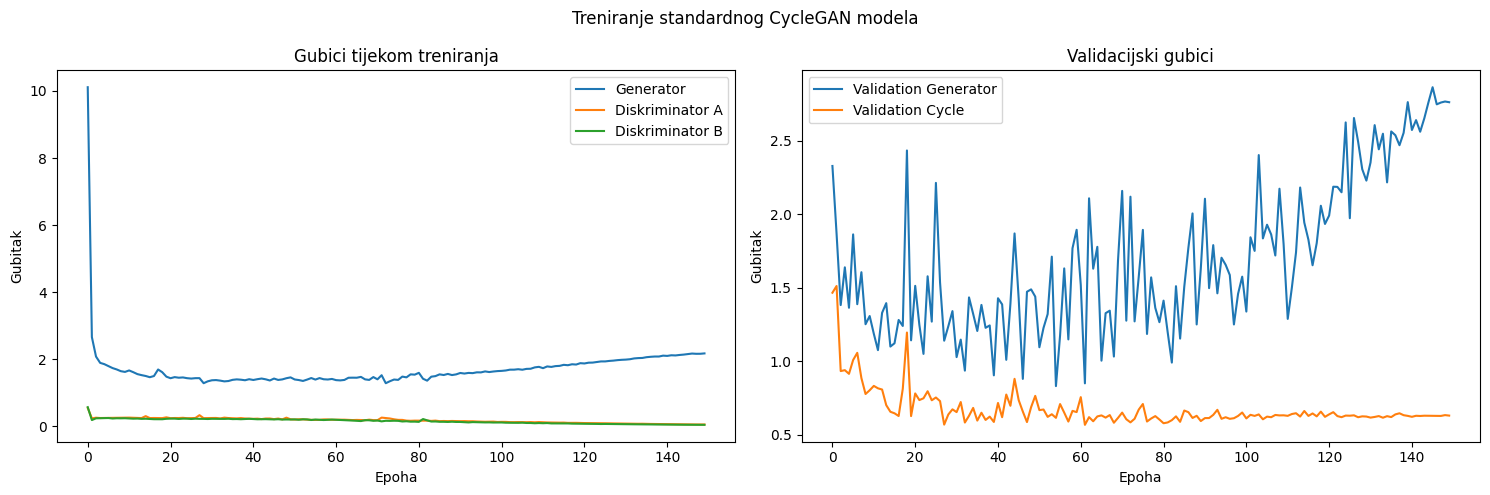

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7135
  MSE: 0.010238
  PSNR: 20.18 dB

T2 -> T1 translacija:
  SSIM: 0.7286
  MSE: 0.009335
  PSNR: 20.55 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9042
  MSE: 0.001584
  PSNR: 28.11 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9094
  MSE: 0.001518
  PSNR: 28.36 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5383
  MSE: 0.016910
  PSNR: 18.00 dB

T2 -> T1 translacija:
  SSIM: 0.5689
  MSE: 0.015415
  PSNR: 18.37 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8547
  MSE: 0.002612
  PSNR: 25.93 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8491
  MSE: 0.002507
  PSNR: 26.18 dB


Vizualizacija rezultata na test setu:


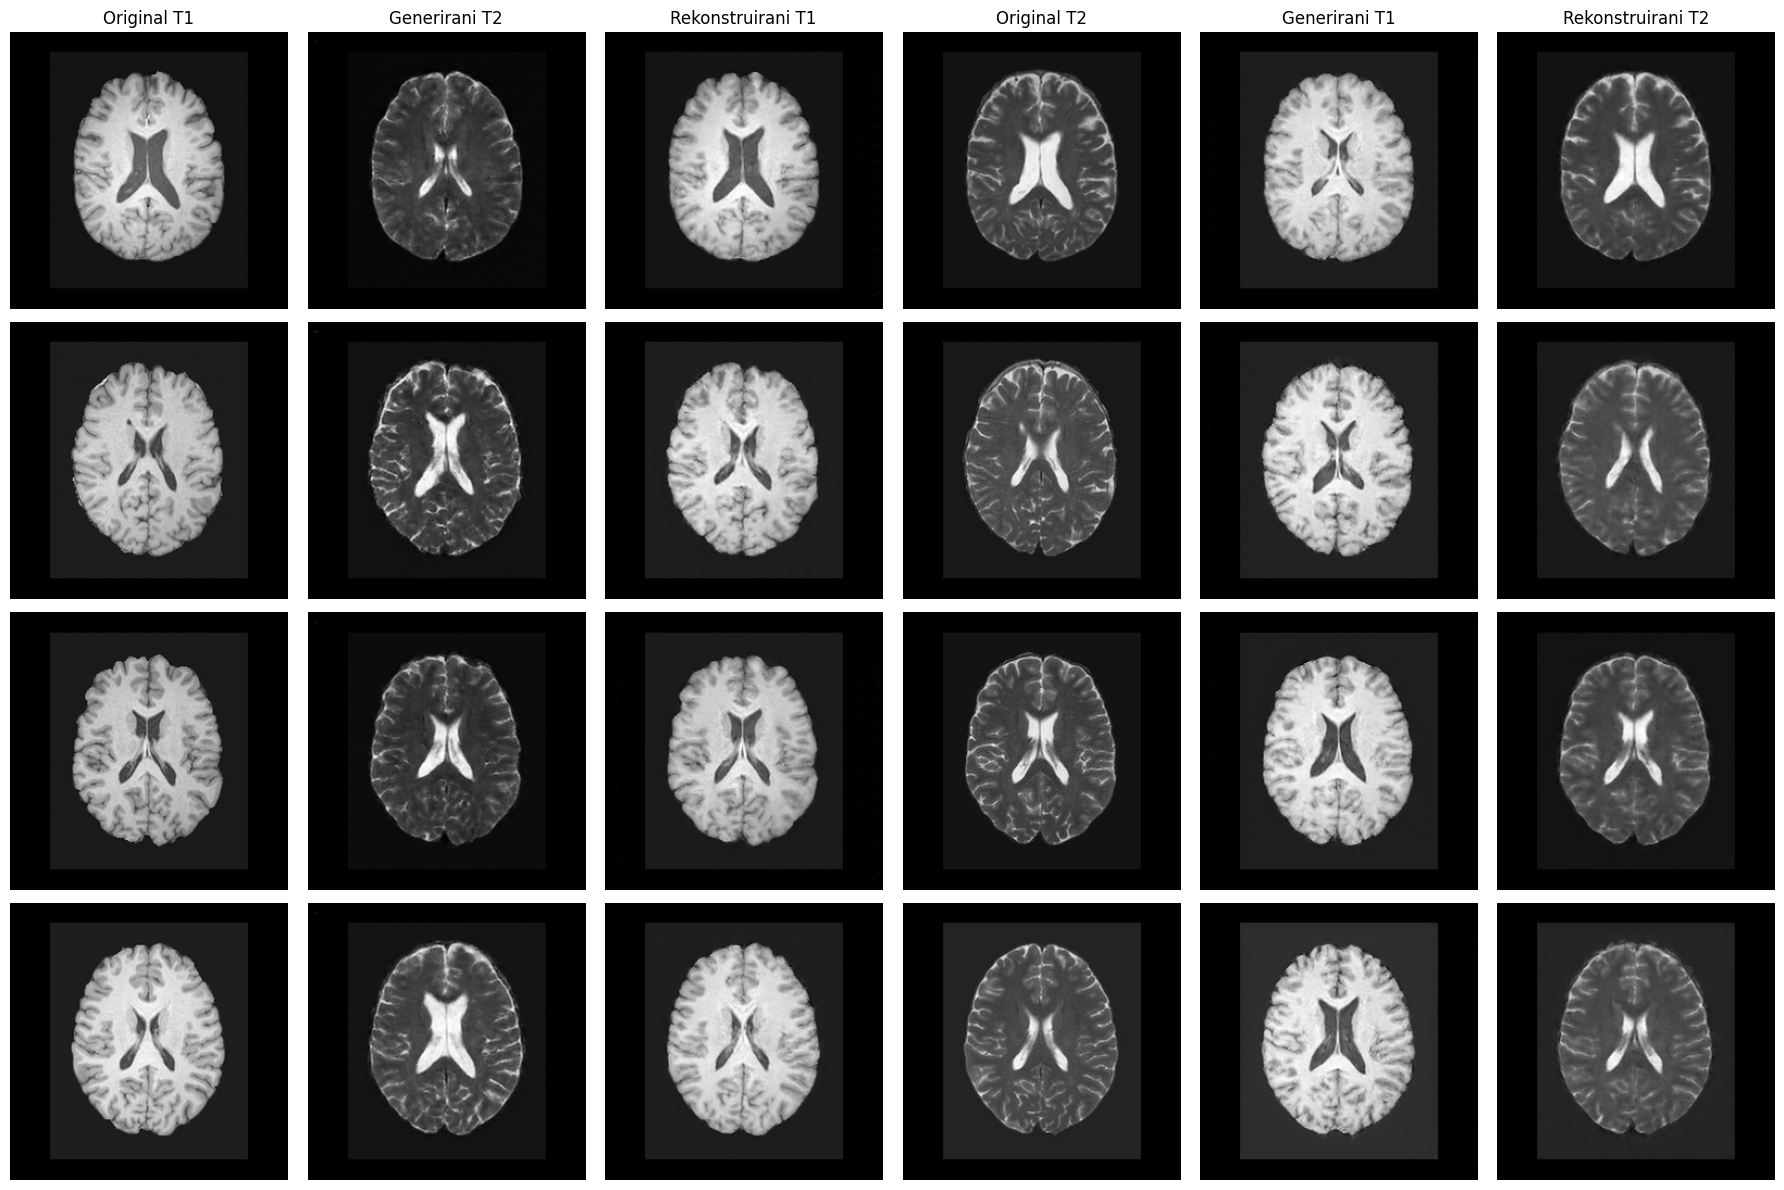

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=4, config=config)

In [11]:
best_G_AB = UNetGeneratorDeep(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = UNetGeneratorDeep(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [12]:
print("Testiranje najboljih modela:")
test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.6905
  MSE: 0.011958
  PSNR: 19.41 dB

T2 -> T1 translacija:
  SSIM: 0.7111
  MSE: 0.009299
  PSNR: 20.54 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9354
  MSE: 0.001231
  PSNR: 29.22 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9270
  MSE: 0.001498
  PSNR: 28.31 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.4960
  MSE: 0.019752
  PSNR: 17.23 dB

T2 -> T1 translacija:
  SSIM: 0.5240
  MSE: 0.015360
  PSNR: 18.36 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8925
  MSE: 0.002034
  PSNR: 27.04 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8789
  MSE: 0.002474
  PSNR: 26.13 dB


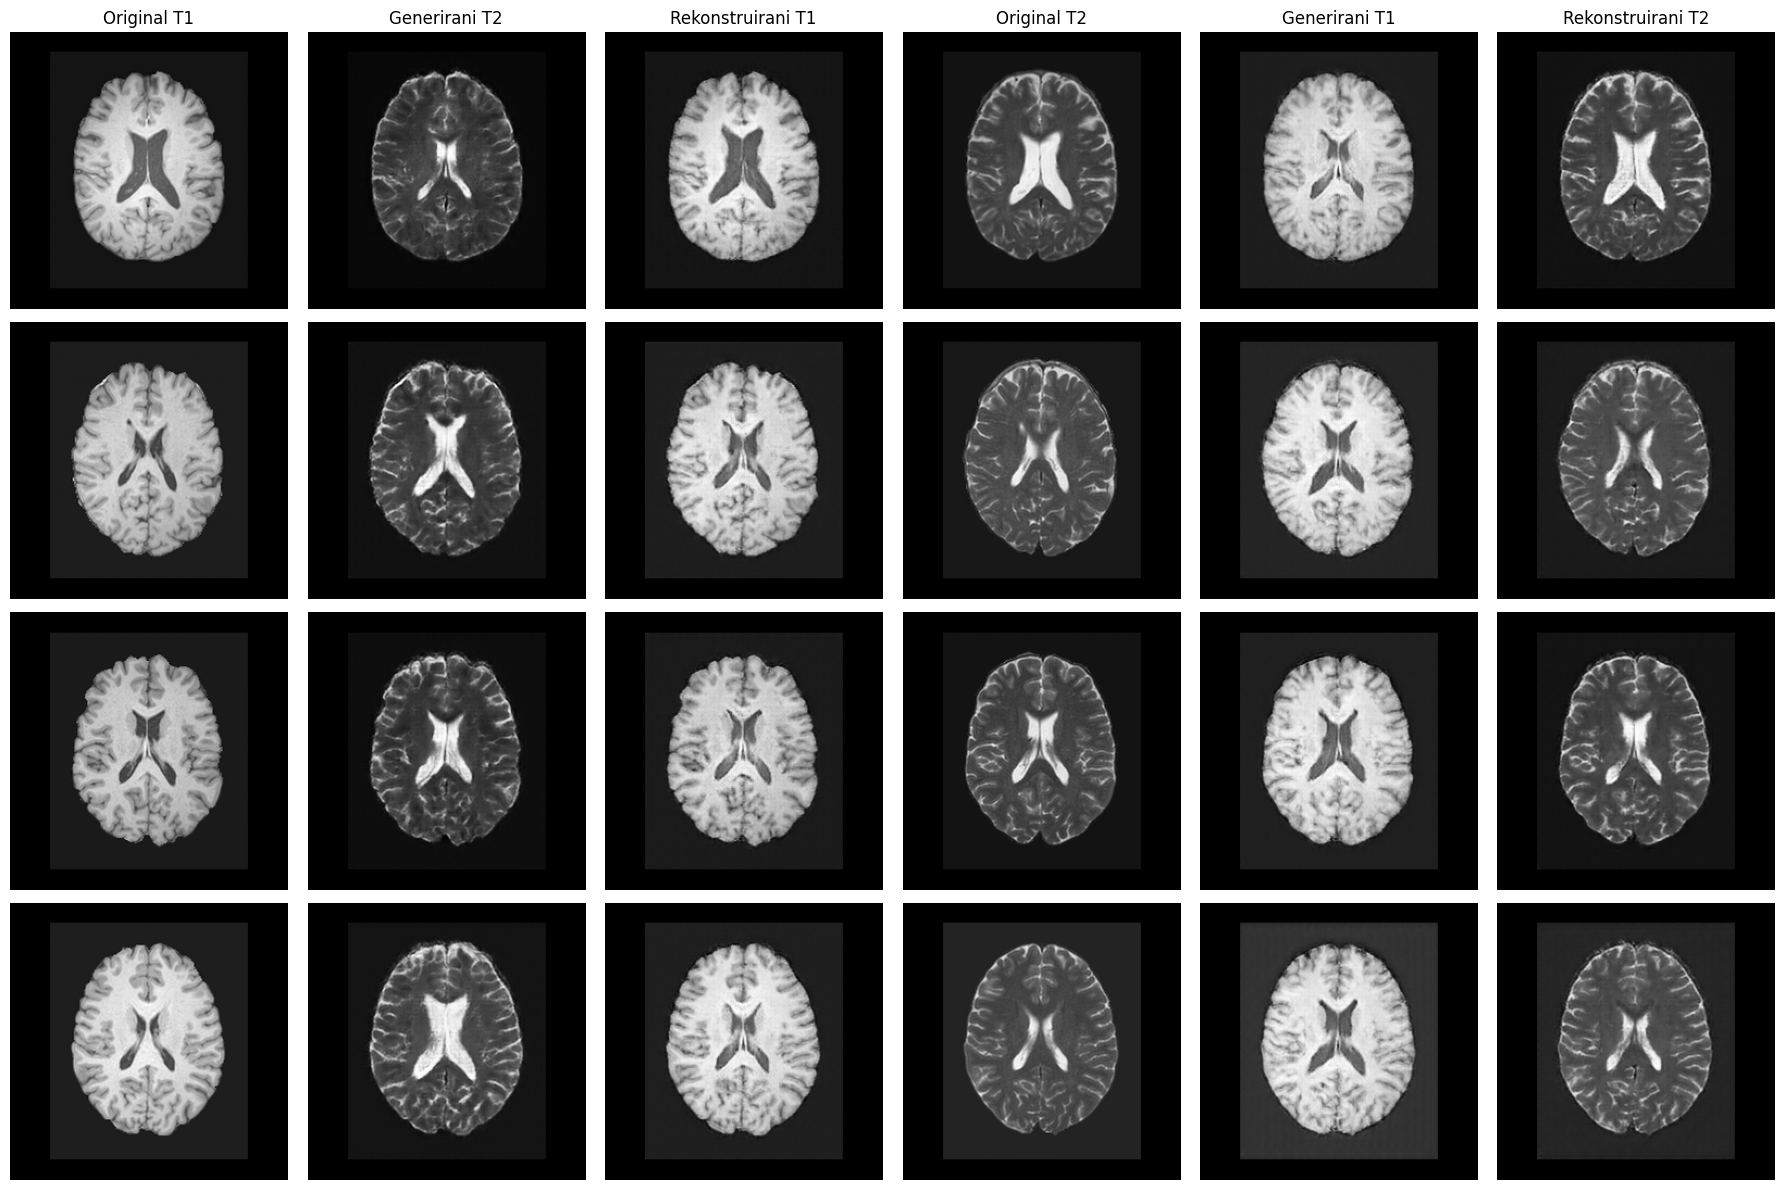

In [13]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=4, config=config
)